# Identificador de peças de xadrez

- Nome: Eduardo Afonso Dutra Silva
- Matricula: 19/0012307

## Propósito

Este artigo tem como propósito demonstrar os passos seguidos para desenvolver um modelo de aprendizado de máquina capaz de identificar as diferentes peças de xadrez existentes utilizando a plataforma `fastai`.

## 1 - Buscando imagens

Começamos por criar uma função capaz de buscar links de imagens na plataforma DuckDuckGo baseando-se em um termo específico e uma quantidade máxima de imagens.

Foi definido um limite de 30 imagens por consulta. Outros números foram testados(40, 50 e 60 imagens) porém este se mostrou o número mais apropriado.

In [1]:
!pip3 install -Uqq fastai duckduckgo_search

from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Pesquisando por '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Os termos a serem pesquisados foram os nomes das peças de xadres em inglês (pois o idioma apresenta melhores resultados do que a pesquisa realizada em português), juntamente com o termo `chess individual`. Foram executadas tentivas com outros termos similares (`unique chess piece`, `only chess piece`, etc) a fim de buscar imagens de uma única peça de xadrez para treinar o algoritmo apropriadamente, porém o termo utilizado se mostrou o mais eficaz.

As imagens foram salvas em pastas que contém o mesmo nome utilizado no termo de pesquisa que originou a imagem.

In [2]:
searches = 'pawn','bishop', 'knight', 'rook', 'queen', 'king'
path = Path('chess_pieces')

from fastai.vision.all import *

for pieceName in searches:
    dest = (path/pieceName)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{pieceName} chess individual'))
    resize_images(path/pieceName, max_size=400, dest=path/pieceName)

Pesquisando por 'pawn chess individual'
Pesquisando por 'bishop chess individual'
Pesquisando por 'knight chess individual'
Pesquisando por 'rook chess individual'
Pesquisando por 'queen chess individual'
Pesquisando por 'king chess individual'


## 2 - Treinamento

Caso tenha ocorrido algum problema no download de alguma imagem o algoritmo poderia ser corrompido. Por este motivo foi utilizado a função a seguir para verificar a integridade das imagens e retira-las da amostra caso tenha havido algum erro.

In [3]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

As imagens selecionadas serão adicionadas a um `DataLoader`que fará a relação entre a imagem e a categoria em que ela se encontra (uma das peças de xadrez). As imagens são separadas entre as que serão utilizadas para treinamento e as que serão utilizadas para validação (25%).

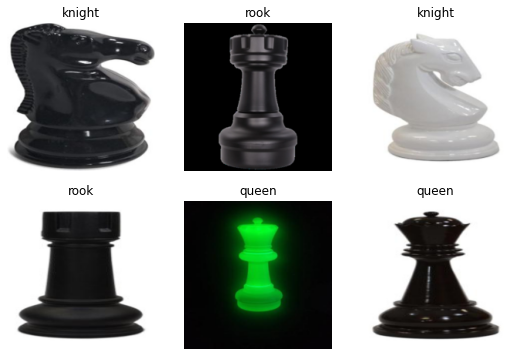

In [4]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.25),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

A quantidade de vezes que a função fine_tune é chamada, para aperfeiçoar o modelo baseado em outro modelo pré-treinado (resnet18), interfere na taxa de erro do modelo, em teoria quanto maior o número de vezes, menor será a taxa. Realizando alguns testes foi possível notar que após a quinta execução os resultados tendem a se manter estagnados, portanto esse foi o número definido para execução da função.

In [5]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.436246,1.830534,0.650602,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.331543,1.074440,0.373494,00:02
1,0.963351,1.024543,0.361446,00:02
2,0.775632,0.977041,0.228916,00:02


Não foi possível chegar a taxa de zero porcento de falha. Acredita-se que o motivo seja que existam poucas imagens em que as peças de xadrez encontram-se sozinhas na imagem. Como o objetivo do algoritmo é identificar uma única peça por vez, caso exista mais de uma peça na mesma imagem de treinamento é possível que haja um problema no processo.

## 3 - Utilização

Iremos baixar uma imagem contendo uma única peça de xadrez para que possamos testar o algoritmo.

Pesquisando por 'one chess piece'


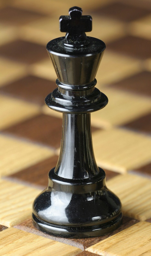

In [6]:
from fastdownload import download_url
dest = 'piece.jpg'
urls = search_images('one chess piece', max_images=1)
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Passando a imagem que acabou de ser baixada para o algoritmo é possível fazer uma predição. Tendo como saída o palpite do algoritmo e a probabilidade de certeza que o algoritmo apresenta.

In [7]:
piece,_,probs = learn.predict(PILImage.create('piece.jpg'))
print(f"This is a: {piece}.")
print(f"Probability it's a {piece}: {probs[0]:.4f}")

This is a: bishop.
Probability it's a bishop: 0.6330


## Referências

[Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data). HOWARD, JEREMY. Kaggle's Jupyter Notebook.

[Practical Deep Learning for Coders 2022](https://course.fast.ai/). HOWARD, JEREMY. FASTAI.
